Курсовой проект "Создание чат-бота в Telegram" 
---

## Ноутбук № 2: построение модели

In [1]:
import pandas as pd
import numpy as np
from numpy import sqrt, argmax
import pickle
import os
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import pyplot

from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn import linear_model
from sklearn.metrics import (roc_auc_score, recall_score, precision_score, f1_score, accuracy_score, auc,
                             plot_confusion_matrix, confusion_matrix, roc_curve, precision_recall_curve)

In [2]:
pd.set_option('display.max_colwidth', None)

In [5]:
path = '../../../data/spam_detection/'

In [6]:
df = pd.read_pickle(os.path.join(path, 'df.pkl'))
print(df.shape)
df

(18393, 2)


,msg,spam
0,Че за возня опять? Возле верного,0
1,Что то похожее на стрельбу было и сейчас три машины полицейских,0
2,А кто-то в курсе что за стрельба?,0
3,"Предупредительный был, видимо , от ментов",0
4,Всё закончилось. Разборки были с поножовщиной,0
...,...,...
18388,"Всем привет, никто не желает учить китайский язык? Я репетиторствую китайским с 2016 года, живу на улице Демин Луг, если есть вопросы и желание пишите )",1
18389,"Уважаемые родители ❗️❗️❗️\nХочу предложить Вам услуги няни👩&zwj;👧&zwj;👦\n\nСобираю группу деток (2-5 детей) для присмотра после садика (с19:00 до 22-23:00) у себя дома. \nВ квартире есть условия для свободной игры, игрушки, горшок, обеспечу вкусным ужином, при необходимости купаю.\n\nСама няня с опытом работы, 🤗могу дать номера телефонов родителей с детками которых ранее присматривала чтоб созвонились узнали обо мне👍\n\n✅Считаю огромным плюсом для родителей то что оплата всего лишь 300 рублей ‼️за вечер 👌",1
18390,"Добрый вечер,могу вам помочь с селективной парфюмерией!\nСама занимаюсь,исключительно оригинал!",1
18391,"Здравствуйте, есть один билет на концерт Сергея Пенкина, завтра в Зелёном Театре, 2000 руб \nНужен сертификат о вакцине или пцр",1


In [7]:
exclude = set(punctuation)
sw = set(get_stop_words("ru"))
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in exclude]
    return " ".join(txt)

df['msg'] = df['msg'].apply(preprocess_text)

In [8]:
df

,msg,spam
0,че за возня опять возле верный,0
1,что то похожий на стрельба быть и сейчас три машина полицейский,0
2,а ктоть в курс что за стрельба,0
3,предупредительный быть видимо от мент,0
4,всё закончиться разборка быть с поножовщина,0
...,...,...
18388,весь привет никтоня желать учить китайский язык я репетиторствовать китайский с 2016 год жить на улица дёмин луг если есть вопрос и желание писать,1
18389,уважаемый родитель ❗️❗️❗️ хотеть предложить вы услуга няни👩zwj👧zwj👦 собирать группа ребёночек 25 ребёнок для присмотр после садик с1900 до 222300 у себя дом в квартира есть условие для свободный игра игрушка горшок обеспечить вкусный ужин принеобходимость купать сам няня с опыт работа 🤗мочь дать номер телефон родитель с ребёночек который ранее присматривать чтоб созвониться узнать о мне👍 ✅считать огромный плюс для родитель то что оплата весь лишь 300 рубль ‼️з вечер 👌,1
18390,добрый вечермочь вы помочь с селективный парфюмерия сам занимаюсьисключительный оригинал,1
18391,здравствуйте есть один билет на концерт сергей пенкин завтра в зелёный театр 2000 руб нужный сертификат о вакцина или пцр,1


In [9]:
df.to_pickle(os.path.join(path, 'df_processed.pkl'))

In [10]:
df = pd.read_pickle(os.path.join(path, 'df_processed.pkl'))
print(df.shape)
df

(18393, 2)


,msg,spam
0,че за возня опять возле верный,0
1,что то похожий на стрельба быть и сейчас три машина полицейский,0
2,а ктоть в курс что за стрельба,0
3,предупредительный быть видимо от мент,0
4,всё закончиться разборка быть с поножовщина,0
...,...,...
18388,весь привет никтоня желать учить китайский язык я репетиторствовать китайский с 2016 год жить на улица дёмин луг если есть вопрос и желание писать,1
18389,уважаемый родитель ❗️❗️❗️ хотеть предложить вы услуга няни👩zwj👧zwj👦 собирать группа ребёночек 25 ребёнок для присмотр после садик с1900 до 222300 у себя дом в квартира есть условие для свободный игра игрушка горшок обеспечить вкусный ужин принеобходимость купать сам няня с опыт работа 🤗мочь дать номер телефон родитель с ребёночек который ранее присматривать чтоб созвониться узнать о мне👍 ✅считать огромный плюс для родитель то что оплата весь лишь 300 рубль ‼️з вечер 👌,1
18390,добрый вечермочь вы помочь с селективный парфюмерия сам занимаюсьисключительный оригинал,1
18391,здравствуйте есть один билет на концерт сергей пенкин завтра в зелёный театр 2000 руб нужный сертификат о вакцина или пцр,1


In [11]:
df['spam'].value_counts()

0    18047
1      346
Name: spam, dtype: int64

In [12]:
df.spam.value_counts()[1] / df.shape[0]

0.018811504376665036

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['msg'], df['spam'],
                                                    test_size=0.2,
                                                    random_state=13,
                                                    stratify=df['spam']
                                                   )

Подберём наилучшее количество фичей в выходной матрице.

In [14]:
df_score = pd.DataFrame(columns=['n_features', 'ROC_AUC'])
i = 0

for n in tqdm(np.arange(50, 5000, 20)):
    count_vect = HashingVectorizer(n_features=n).fit(X_train.values)

    xtrain = count_vect.transform(X_train)
    xtest = count_vect.transform(X_test)

    lr = linear_model.LogisticRegression(class_weight="balanced").fit(xtrain, y_train)
    score = roc_auc_score(y_test, lr.predict_proba(xtest)[:, 1])
    df_score.loc[i] = [n, score]
    i += 1

100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [01:10<00:00,  3.50it/s]


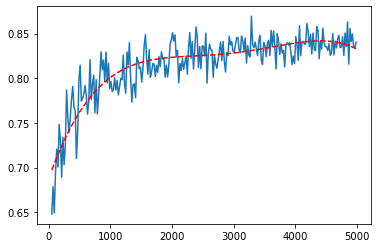

In [15]:
plt.plot(df_score['n_features'], df_score['ROC_AUC'])
z = np.polyfit(df_score['n_features'], df_score['ROC_AUC'], 4)
p = np.poly1d(z)
plt.plot(df_score['n_features'], p(df_score['n_features']),"r--")

plt.show()

In [16]:
df_score.tail(12)

,n_features,ROC_AUC
236,4770.0,0.846570
237,4790.0,0.825453
238,4810.0,0.850689
239,4830.0,0.835525
240,4850.0,0.863098
241,4870.0,0.815802
242,4890.0,0.855783
243,4910.0,0.841387
244,4930.0,0.849633
245,4950.0,0.834598


In [17]:
count_vect = HashingVectorizer(n_features=4800).fit(X_train.values)

xtrain = count_vect.transform(X_train)
xtest = count_vect.transform(X_test)

lr = linear_model.LogisticRegression(class_weight="balanced").fit(xtrain, y_train)

y_proba = lr.predict_proba(xtest)[:, 1]
y_predict = lr.predict(xtest)

In [18]:
roc_auc_score(y_test, y_predict)

0.7786803966437834

In [19]:
recall_score(y_test, y_predict)

0.5942028985507246

In [20]:
precision_score(y_test, y_predict)

0.23563218390804597

In [21]:
f1_score(y_test, y_predict)

0.3374485596707819

In [22]:
compare_df = pd.DataFrame(X_test)
compare_df['proba'] = y_proba
compare_df['predict spam'] = y_predict
compare_df[compare_df['proba'] > 0.97]

,msg,proba,predict spam
18088,❗️❗️❗️❗️❗️всем здравствуйте предоставление скидка до 50 в топ 15 страховой компаний❗️❗️❗️❗️м работать с весь страховой компания по прямой агентский договор специалист доставить документ бесплатно по москва и мо бесплатно провести осмотр как при оформление каско так и осаго оплата производиться после получение полис оплата наличнымикартойпо счёт мочь организовать вы оплата полис в офис страховой компания который вы выбрать ✅все вид страхование для физ и юр лицо ✅страхование автотранспорт ✅страхование квартира и загородный дом ✅дмс страхование отнесчастный случай в тот число для человек заниматься спорт ✅страхование для выезжать за рубеж и тд ✅предоставление скидка до 50 в топ 15 страховой компания ✅цена маленький дилер и агент ✅предоставление персональный менеджер на весь срок страхование а так же юридический поддержка на случай возникновение трение с страховой компания звонить либо писать алексей 89257294631,0.973221,1
18298,добрый день всем❗️❗️❗️❗️❗️предоставление скидка до 50 в топ 15 страховой компаний❗️❗️❗️❗️м работать с весь страховой компания по прямой агентский договор специалист доставить документ бесплатно по москва и мо бесплатно провести осмотр как при оформление каско так и осаго страхование такси грузовой автомобиль оплата производиться после получение полис оплата наличнымикартойпо счёт мочь организовать вы оплата полис в офис страховой компания который вы выбрать ✅все вид страхование для физ и юр лицо ✅страхование автотранспорт ✅страхование квартира и загородный дом ✅дмс страхование отнесчастный случай в тот число для человек заниматься спорт ✅страхование для выезжать за рубеж и тд ✅предоставление скидка до 50 в топ 15 страховой компания ✅цена маленький дилер и агент ✅предоставление персональный менеджер на весь срок страхование а так же юридический поддержка на случай возникновение трение с страховой компания алексей 89257294631,0.976083,1
18079,весь добрый вечер для новый студия растяжка в трц новоизмайловский инстаграмм tvorimtelom требоваться тренер и админ на вечерний часы если вы или ваш знакомый интересно писать в лс,0.977849,1
18067,добрый вечер весь участник группа снять жильё для семейный пара с два детьмиребёнок 10 и 13 год в новый измайлово,0.977756,1
4654,добрый вечер никтоня сдавать однокомнатный квартира или студия,0.972027,1
14515,продавать квартира,0.990440,1
18147,нужный квартира посуточно для молодой пара жить постоянно в ни не большой ремонт в наш квартира,0.975729,1


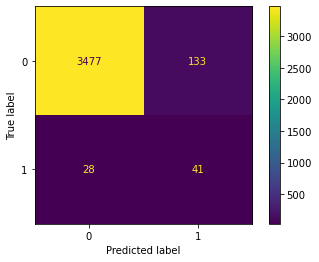

In [23]:
plot_confusion_matrix(lr, xtest, y_test)  
plt.show()  

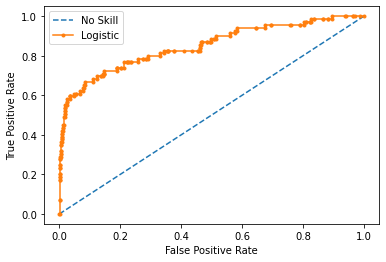

In [24]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

In [49]:
pkl_path_filename = os.path.join(path, 'lr_model.pkl')
with open(pkl_path_filename, 'wb') as file:
    pickle.dump(lr, file)

In [4]:
pkl_path_filename = os.path.join(path, 'lr_model.pkl')
with open(pkl_path_filename, 'rb') as file:
    lr = pickle.load(file)
lr

LogisticRegression(class_weight='balanced')

In [25]:
pkl_path_filename = os.path.join(path, 'count_vectorizer.pkl')
with open(pkl_path_filename, 'wb') as file:
    pickle.dump(count_vect, file)

In [27]:
pkl_path_filename = os.path.join(path, 'count_vectorizer.pkl')
with open(pkl_path_filename, 'rb') as file:
    count_vect = pickle.load(file)
count_vect

HashingVectorizer(n_features=4800)

In [25]:
gmeans = sqrt(tpr * (1-fpr))

In [26]:
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.242607, G-Mean=0.786


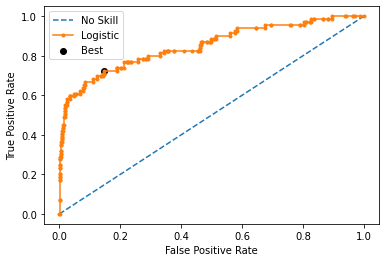

In [52]:
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

In [39]:
pred_proba_df = pd.DataFrame(lr.predict_proba(xtest))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    y_test_pred = pred_proba_df.applymap(lambda x: 1 if x > i else 0)
    test_accuracy = accuracy_score(y_test.to_numpy().reshape(y_test.to_numpy().size, 1),
                                           y_test_pred.iloc[:,1].to_numpy().reshape(y_test_pred.iloc[:,1].to_numpy().size, 1))
    print('Our testing accuracy is {}'.format(test_accuracy))

    print(confusion_matrix(y_test.to_numpy().reshape(y_test.to_numpy().size,1),
                           y_test_pred.iloc[:,1].to_numpy().reshape(y_test_pred.iloc[:,1].to_numpy().size,1)))


******** For i = 0.05 ******
Our testing accuracy is 0.34411524870888827
[[1201 2409]
 [   4   65]]

******** For i = 0.1 ******
Our testing accuracy is 0.607773851590106
[[2179 1431]
 [  12   57]]

******** For i = 0.15 ******
Our testing accuracy is 0.7322642022288666
[[2640  970]
 [  15   54]]

******** For i = 0.2 ******
Our testing accuracy is 0.8089154661592824
[[2925  685]
 [  18   51]]

******** For i = 0.25 ******
Our testing accuracy is 0.8556673008969828
[[3100  510]
 [  21   48]]

******** For i = 0.3 ******
Our testing accuracy is 0.8910029899429193
[[3232  378]
 [  23   46]]

******** For i = 0.35 ******
Our testing accuracy is 0.9149225332970916
[[3321  289]
 [  24   45]]

******** For i = 0.4 ******
Our testing accuracy is 0.9306876868714324
[[3382  228]
 [  27   42]]

******** For i = 0.45 ******
Our testing accuracy is 0.9453655884751291
[[3436  174]
 [  27   42]]

******** For i = 0.5 ******
Our testing accuracy is 0.9562381081815711
[[3477  133]
 [  28   41]]

****

(0.0, 1.0)

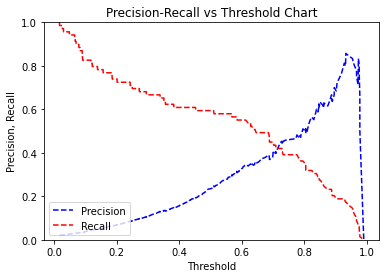

In [43]:
Predict test_y values and probabilities based on fitted logistic regression model
precision, recall, thresholds = precision_recall_curve(y_test, y_proba) 
pr_auc = auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])